In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fed_data = ["CPIAUCSL.csv", "RRVRUSQ156N.csv", "MORTGAGE30US.csv"]
zillow_data = "Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_month.csv"

# Formatting for better readability with Fed data
dfs = [pd.read_csv(f, parse_dates=True, index_col='DATE') for f in fed_data]

# Load Zillow data
zillow = pd.read_csv(zillow_data)

# Here we select a specific row (e.g., United States average) and transpose it
zillow = zillow.iloc[0:1, 5:].T
zillow.index = pd.to_datetime(zillow.index)
zillow.columns = ["price"]

# Merge economic data with Zillow price data
price_data = pd.concat(dfs + [zillow], axis=1).ffill().dropna()

## 2. Spatio-Temporal Feature Engineering

We use cyclical encoding to represent temporal features of the market (summer being peak season and winter being off-peak).

In [ ]:
def create_features(df):
    # Target: to predict the price 3 months into the future
    df["target"] = df["price"].shift(-3)
    
    # 1. Temporal: Seasonal Sine/Cosine
    df["month"] = df.index.month
    df["month_sin"] = np.sin(2 * np.pi * df["month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["month"] / 12)
    
    # 2. Market Trend: Price momentum (3-month and 12-month change)
    df["price_momentum"] = df["price"].pct_change(3)
    df["annual_change"] = df["price"].pct_change(12)
    
    return df.dropna()

price_data = create_features(price_data)

## 3. Backtesting engine

In [4]:
from sklearn.ensemble import RandomForestRegressor

def backtest(data, model, predictors, start=24, step=6):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        
        model.fit(train[predictors], train["target"])
        preds = model.predict(test[predictors])
        
        combined = pd.concat([test["target"], pd.Series(preds, index=test.index)], axis=1)
        combined.columns = ["actual", "prediction"]
        all_predictions.append(combined)
        
    return pd.concat(all_predictions)

# Define variables and run model
predictors = ["CPIAUCSL", "MORTGAGE30US", "month_sin", "month_cos", "price_momentum"]
rf = RandomForestRegressor(n_estimators=100, min_samples_split=10, random_state=1)

predictions = backtest(price_data, rf, predictors)

## 4. Training and Evaluation

We evaluate using Median Absolute Percentage Error (MdAPE) to shadow Zillow’s accuracy metrics.

Settlyfe LyfeEstimate Accuracy (MdAPE): 0.93%


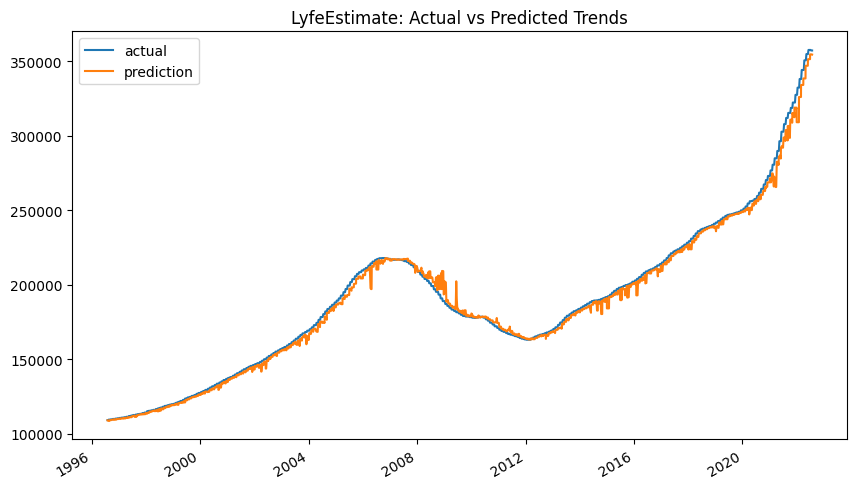

In [5]:
# Calculate MdAPE
mdape = np.median(np.abs((predictions["actual"] - predictions["prediction"]) / predictions["actual"])) * 100
print(f"Settlyfe LyfeEstimate Accuracy (MdAPE): {mdape:.2f}%")

# Visualize Results
predictions.plot(figsize=(10, 6))
plt.title("LyfeEstimate: Actual vs Predicted Trends")
plt.show()